## Simplest version of the transportation model
This is a demo for a transportation system with 2 patches and 2 connecting corridors, which may have different or identical capacities ($\beta_1$ and $\beta_2$).

Next steps
- Convert emissions/distance into emissions/time (as a function of avg speed, which is a function of congestion) - fully endogenous model
    - DONE
- Try to model U-shaped curve with something like a (x-40)**4 + 1...
    - NOT STARTED
- replace Greenshield's model with arctan function
    - DONE
- rewrite functions using matrix notation
    - IN PROGRESS

What's missing compared to XPPAUT travel_4.ode?
- power function (for tapering off near 0)
- urban sponge

In [1]:
using Plots
using LinearAlgebra
using LaTeXStrings
using Roots
using DifferentialEquations
using Interpolations
using RecursiveArrayTools
using QuadGK
using Printf

## Simple demo
2 patches, 2 corridors connecting each patch to its neighbor. All represented explicitly (no matrix notation)

Function for calculating populations N (of each patch and corridor) at next time step. Demo case for two patches with two connecting corridors. Final version will use matrix notation.

In [2]:
function traffic_flow_demo!(dN, N, p, t)
    #=
        Returns (change in place)
            - dN: array-like, size (6,)
                    population values at next time step
        Arguments
            - dN: array-like, size (6,)
                    population values at next time step
            - N: array-like, size (6,)
                    population values at current time step
                    N = [P¹, P², C¹₁₂, C¹₂₁, C²₁₂, C²₂₁]
            - p: array-like, size (6,)
                    parameters
                    p = [α₁, α₂, β₁, β₂, p1_out, p2_out]
    =#
    P¹ = N[1]      # population in patch 1
    P² = N[2]      # population in patch 2
    C¹₁₂ = N[3]    # population in corridor 1, lane from patch 1 to patch 2
    C¹₂₁ = N[4]    # population in corridor 1, lane from patch 2 to patch 1
    C²₁₂ = N[5]    # population in corridor 2, lane from patch 1 to patch 2
    C²₂₁ = N[6]    # population in corridor 2, lane from patch 2 to patch 1

    α₁ = p[1]       # tolerance for congestion, originators in patch 1
    α₂ = p[2]       # tolerance for congestion, originators in patch 2
    β₁ = p[3]       # inverse road capacity, corridor 1
    β₂ = p[4]       # inverse road capacity, corridor 2
    p1_out = p[5]   # overall demand for leaving P1
    p2_out = p[6]   # overall demand for leaving P2

    # Fluxes
    F₁ᶜ¹ = p1_out * exp(-β₁ * α₁ * C¹₁₂) * P¹   # flux from patch 1 into corridor 1 (implicitly heading towards patch 2)
    F₂ᶜ¹ = p2_out * exp(-β₁ * α₂ * C¹₂₁) * P²   # flux from patch 2 into corridor 1 (implicitly heading towards patch 1)
    F₁ᶜ² = p1_out * exp(-β₂ * α₁ * C²₁₂) * P¹   # flux from patch 1 into corridor 2 (implicitly heading towards patch 2)
    F₂ᶜ² = p2_out * exp(-β₂ * α₂ * C²₂₁) * P²   # flux from patch 2 into corridor 2 (implicitly heading towards patch 1)

    Fc₁¹ = exp(-β₁ * C¹₂₁) * C¹₂₁     # flux from corridor 1 into patch 1 (implicitly lane from p2 to p1)
    Fc₁² = exp(-β₁ * C¹₁₂) * C¹₁₂     # flux from corridor 1 into patch 2 (implicitly lane from p1 to p2)
    Fc₂¹ = exp(-β₂ * C²₂₁) * C²₂₁     # flux from corridor 2 into patch 1 (implicitly lane from p2 to p1)
    Fc₂² = exp(-β₂ * C²₁₂) * C²₁₂     # flux from corridor 2 into patch 2 (implicitly lane from p1 to p2)
    
    # Net changes to state variables
    dN[1] = Fc₁¹ + Fc₂¹ - F₁ᶜ¹ - F₁ᶜ² # change in population Patch 1
    dN[2] = Fc₁² + Fc₂² - F₂ᶜ¹ - F₂ᶜ² # change in population Patch 2
    dN[3] = F₁ᶜ¹ - Fc₁² # change in population Corridor 1 lane from p1 to p2
    dN[4] = F₂ᶜ¹ - Fc₁¹ # change in population Corridor 1 lane from p2 to p1
    dN[5] = F₁ᶜ² - Fc₂² # change in population Corridor 2 lane from p1 to p2
    dN[6] = F₂ᶜ² - Fc₂¹ # change in population Corridor 2 lane from p2 to p1
end
# Where to put conservation law??

traffic_flow_demo! (generic function with 1 method)

Run diff eqs for 100 time steps, with initial conditions P¹=0, P²=C¹₁₂=C¹₂₁=C²₁₂=C²₂₁=0, and parameters given below. Plot outputs for each population.

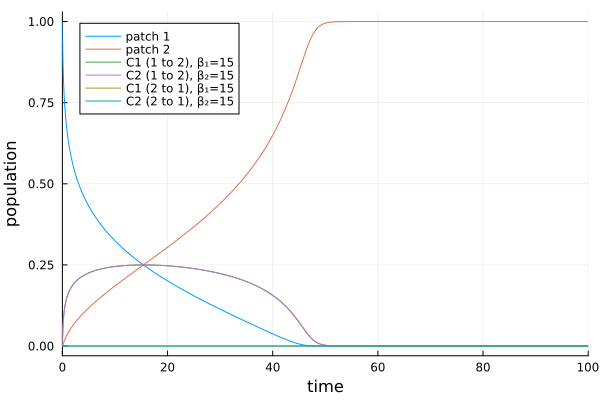

In [3]:
# Choose parameters
α₁ = 1
α₂ = 1
β₁ = 15
β₂ = 15
p1_out = 1
p2_out = 0
p = [α₁, α₂, β₁, β₂, p1_out, p2_out]

# Solve diff eq
N0 = [1; 0.; 0; 0; 0; 0]                              # set initial conditions: [P¹, P², C¹₁₂, C¹₂₁, C²₁₂, C²₂₁]
tspan = (0.0, 100.0)                                  # set time span
prob = ODEProblem(traffic_flow_demo!, N0, tspan, p)   # create problem (system of diff eqs)
sol = solve(prob)                                     # solve problem

# Plot each population over time 
plot(sol, idxs = (0,1), xlabel="time", ylabel="population", label="patch 1")
plot!(sol, idxs = (0,2), xlabel="time", ylabel="population", label="patch 2")
plot!(sol, idxs = (0,3), xlabel="time", ylabel="population", label="C1 (1 to 2), β₁=$β₁")
plot!(sol, idxs = (0,5), xlabel="time", ylabel="population", label="C2 (1 to 2), β₂=$β₂")
plot!(sol, idxs = (0,4), xlabel="time", ylabel="population", label="C1 (2 to 1), β₁=$β₁")
plt = plot!(sol, idxs = (0,6), xlabel="time", ylabel="population", label="C2 (2 to 1), β₂=$β₂")
savefig(plt, "julia_plots/traffic_flows_β₁_$β₁" * "_β₂_$β₂" * ".png")
display(plt)

# Plot phase space
#plot(sol, idxs = (1,2), xlabel="P1", ylabel="P2")

### Functions to convert traffic densities to average speeds

In [4]:
# Calculate speeds from densities
v_f = 90             # free-flow velocity, 90 km/hr, same for C1 and C2
C1_jam = 1 / β₁      # jam density for C1 (causes avg speed = 0)
C2_jam = 1 / β₂      # jam density for C2 (causes avg speed = 0)
C1_half = C1_jam / 2 # threshold density for C1 (causes avg speed = 1/2 free-flow speed)
C2_half = C2_jam / 2 # threshold density for C2 (causes avg speed = 1/2 free-flow speed)

function calc_space_mean_speed_alternative(v_f, C, C_half; a=1)
    #=
        Returns:
            - u_s: float 
                average speed for vehicles in a given traffic flow. If negative, return 0.
        Arguments:
            - v_f: float
                free-flow velocity
            - C: float
                vehicle density (in corridor C)
            - C_half:
                threshold value of vehicle density, where u_s = 1/2 * v_f
    =#
    u_s = - (v_f / pi) * atan(a*(C - C_half)) + (v_f / 2)
    return u_s > 0 ? u_s : 0
end

# NOT USED - Greenshield's model
function calc_space_mean_speed_greenshields(v_f, k, k_jam)
    u_s = v_f - (k/k_jam)*v_f
    return u_s > 0 ? u_s : 0
end


calc_space_mean_speed_greenshields (generic function with 1 method)

### Functions to convert average speeds to emission rates

In [5]:
# Make a U-shaped curve using data from the California paper
start = 5 
my_step = 5
stop = 100
mph_to_kmh = 1.60934
speed_arr = collect(start:my_step:stop) * mph_to_kmh # convert mph to kmh
emissions_arr = [1200, 950, 700, 500, 425, 350, 325, 310, 309, 308, 308, 308, 309, 320, 330, 350, 375, 400, 450, 550] * mph_to_kmh
plot(speed_arr, emissions_arr)

# Interpolate: emissions as a function of speed
interp_fn = linear_interpolation(speed_arr, emissions_arr, extrapolation_bc=Line())

# Calculate emissions from a given array of speeds
function calc_emissions_from_speed(vehicle_pop_arr, my_speed_arr, interp_fn)
    #=
        Returns:
            - emissions: array (dim 1) 
                emission rates (g/km) for whole traffic volume (all vehicles) at each
                time step
        Arguments:
            - vehicle_pop_arr: array (dim 1) of vehicle population densities at 
              each time step
            - my_speed_arr: array (dim 1) of avg vehicle speeds at each time step
            - interp_fn: function (interpolated) relating speeds to emissions
    =#
    interpolated_emission_per_vehicle = interp_fn(my_speed_arr)
    emissions = interpolated_emission_per_vehicle .* my_speed_arr .* vehicle_pop_arr
    return emissions
end

# NOT USED - Calculate flow volume
function calc_flow(vehicle_pop_arr, v_f, k_jam)
    q = v_f .* vehicle_pop_arr - (v_f / k_jam) .* vehicle_pop_arr.^2
    return q
end

calc_flow (generic function with 1 method)

### Functions to convert emissions rates to total emissions

In [6]:
function integrate_emissions(x, y, a, b)
    # Create an interpolation function over data points
    interp_func = LinearInterpolation(x, y, extrapolation_bc=Line())

    # Integrate the interpolated function from a to b
    result, error = quadgk(interp_func, a, b)

    return result, error
end

integrate_emissions (generic function with 1 method)

### Calculate Expected Emissions for travel on C1 and C2

In [7]:
# Calculate emission rates for C1
pop_C1 = sol[3, :]
time = sol.t
C1_speeds = calc_space_mean_speed_alternative.(v_f, pop_C1, C1_half)
C1_emissions = calc_emissions_from_speed(pop_C1, C1_speeds, interp_fn)
C1_flow = calc_flow(pop_C1, v_f, C1_jam)

# Same for C2
pop_C2 = sol[5, :]
time = sol.t
C2_speeds = calc_space_mean_speed_alternative.(v_f, pop_C2, C2_half)
C2_emissions = calc_emissions_from_speed(pop_C2, C2_speeds, interp_fn)
C2_flow = calc_flow(pop_C2, v_f, C2_jam)

# Total emissions
C1_total_emissions = integrate_emissions(time, C1_emissions, 0.0, 100.0)[1] # [1] for value, [2] for error
formatted_C1_em = @sprintf("%.3f", C1_total_emissions)

C2_total_emissions = integrate_emissions(time, C2_emissions, 0.0, 100.0)[1]
formatted_C2_em = @sprintf("%.3f", C2_total_emissions)

Total_emissions = C1_total_emissions + C2_total_emissions
formatted_T_em = @sprintf("%.3f", Total_emissions)

C1_fraction_emissions = 100 * C1_total_emissions / Total_emissions
formatted_C1_fraction = @sprintf("%.2f", C1_fraction_emissions)

C2_fraction_emissions = 100 * C2_total_emissions / Total_emissions
formatted_C2_fraction = @sprintf("%.2f", C2_fraction_emissions)

"50.00"

Plot everything at once

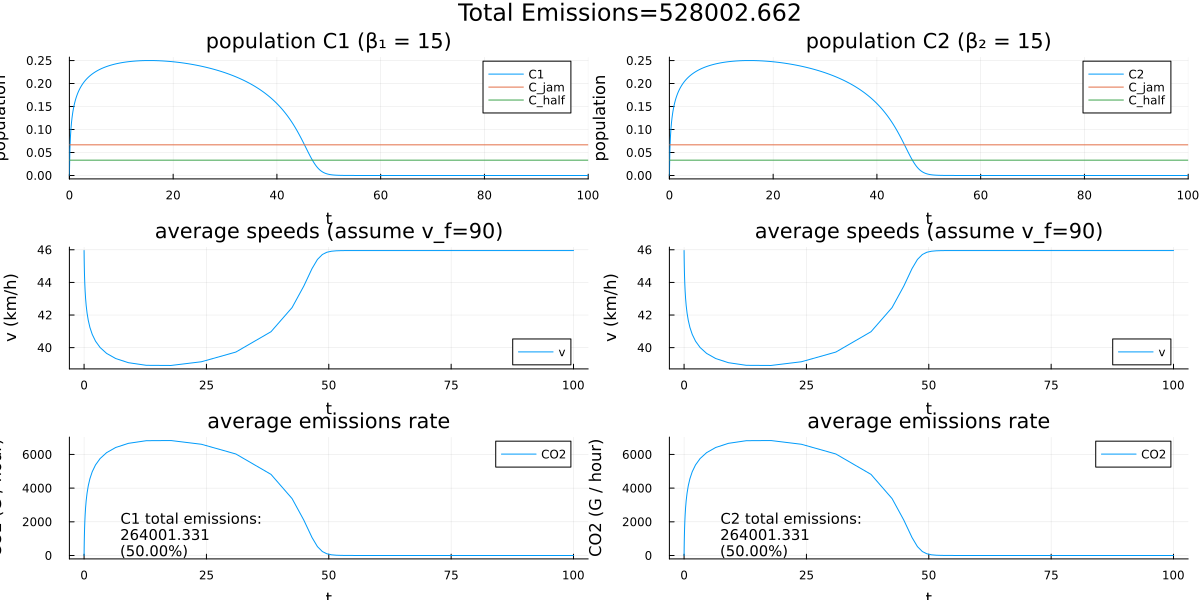

In [8]:
# For annotations
x_fraction = 0.1; y_fraction = 0.2

# C1 plots
plt1 = plot(sol, idxs=(0,3), xlabel="t", ylabel="population", label="C1", title="population C1 (β₁ = $β₁)")
plt1 = plot!(plt1, [0,100], repeat([C1_jam], 2), label="C_jam")
plt1 = plot!(plt1, [0,100], repeat([C1_half], 2), label="C_half")
plt2 = plot(sol.t, C1_speeds, xlabel="t", ylabel="v (km/h)", label="v", title="average speeds (assume v_f=90)")
plt3 = plot(sol.t, C1_emissions, xlabel="t", ylabel="CO2 (G / hour)", label="CO2", title="average emissions rate")

# Annotate with total emissions
xmin, xmax = xlims()
ymin, ymax = ylims()
x_position = xmin + x_fraction * (xmax - xmin)
y_position = ymin + y_fraction * (ymax - ymin)
plt3 = annotate!(x_position, y_position, text("C1 total emissions:\n$formatted_C1_em\n($formatted_C1_fraction%)", :left, 10, :black))

# Assemble C1 plot
C1_plt = plot(plt1, plt2, plt3, layout = grid(3,1, heights=(1/3,1/3,1/3)), size=(600,600))

# Optional - save C1 plot
#savefig(plt, "julia_plots/congestion_to_emissions_C1β₁_$β₁" * ".png")
#display(plt)

# C2 plots
plt1 = plot(sol, idxs=(0,5), xlabel="t", ylabel="population", label="C2", title="population C2 (β₂ = $β₂)")
plt1 = plot!(plt1, [0,100], repeat([C2_jam], 2), label="C_jam")
plt1 = plot!(plt1, [0,100], repeat([C2_half], 2), label="C_half")
plt2 = plot(sol.t, C2_speeds, xlabel="t", ylabel="v (km/h)", label="v", title="average speeds (assume v_f=90)")
plt3 = plot(sol.t, C2_emissions, xlabel="t", ylabel="CO2 (G / hour)", label="CO2", title="average emissions rate")

# Annotate with total emisssions
xmin, xmax = xlims()
ymin, ymax = ylims()
x_position = xmin + x_fraction * (xmax - xmin)
y_position = ymin + y_fraction * (ymax - ymin)
plt3 = annotate!(x_position, y_position, text("C2 total emissions:\n$formatted_C2_em\n($formatted_C2_fraction%)", :left, 10, :black))

# Assemble C2 plot
C2_plt = plot(plt1, plt2, plt3, layout = grid(3,1, heights=(1/3,1/3,1/3)), size=(600,600))

# Optional - save C2 plot
#savefig(plt, "julia_plots/congestion_to_emissions_C2_β₂_$β₂" * ".png")
#display(plt)

# Combine plots
plt = plot(C1_plt, C2_plt, layout = grid(1,2, widths=(1/2,1/2)), size=(1200, 600), plot_title="Total Emissions=$formatted_T_em")
#supertitle!(plt, title="Total Emissions=$formatted_T_em")

savefig(plt, "julia_plots/congestion_to_emissions_C1_and_C2_β₁_$β₁" * "_β₂_$β₂" * ".png")
display(plt)

## Generalized model (Matrix Notation)
Arbitrary number of patches. Currently maximum of 1 corridor connecting each patch to any of its neighbors. Next version will include possibility of multiple corridors connecting the same pair of patches.

Notes
- exp.(C) needed whenever C is a matrix. exp(C) tries to perform the matrix exponential, which is only defined for square matrices